In [5]:

import matplotlib.pyplot as plt
import numpy as np
from aim import Run
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import os
from torch.autograd import grad
import swd_optim

main_dir = '../wind-profiles/updated'
# directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision=10)
# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data_train = torch.empty(0, total_size - segment_to_skip, 5)
y_data_train = torch.empty(0, total_size - segment_to_skip, 3)
X_data_test = torch.empty(0, total_size - segment_to_skip, 5)
y_data_test = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Training_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Training_files/{directory}/{file_}', delimiter=',',
                           header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'],
                           skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])

        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue

        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(
            data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(
            data[['n', 'v', 'T']].values, dtype=torch.float32)

        X_data_train = torch.cat(
            (X_data_train, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_train = torch.cat(
            (y_data_train, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/Validation_files/{directory}'):
        data = pd.read_csv(f'{main_dir}/Validation_files/{directory}/{file_}', delimiter=',',
                           header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'],
                           skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])

        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue

        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(
            data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(
            data[['n', 'v', 'T']].values, dtype=torch.float32)

        X_data_test = torch.cat(
            (X_data_test, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data_test = torch.cat(
            (y_data_test, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)


In [25]:
# save tensors to file
# swap last two dimensions
#X_data_train = X_data_train.permute(0, 2, 1)
#y_data_train = y_data_train.permute(0, 2, 1)
#X_data_test = X_data_test.permute(0, 2, 1)
#y_data_test = y_data_test.permute(0, 2, 1)
#torch.save(X_data_train, 'X_data_train.pt')
#torch.save(y_data_train, 'y_data_train.pt')
#torch.save(X_data_test, 'X_data_test.pt')
#torch.save(y_data_test, 'y_data_test.pt')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:

# load tensors from file
X_train = torch.load('X_data_train.pt').to(torch.float64)
y_train = torch.load('y_data_train.pt').to(torch.float64)
X_test = torch.load('X_data_test.pt').to(torch.float64)
y_test = torch.load('y_data_test.pt').to(torch.float64)

In [8]:
reduced = y_train[:, 0, :].min(axis=1)[0]
np.where(reduced.detach().numpy() < 0)

(array([3051, 5294, 6797, 6863, 6926, 7004, 9184, 9236, 9623, 9692]),)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([10593, 5, 540]),
 torch.Size([10593, 3, 540]),
 torch.Size([1177, 5, 540]),
 torch.Size([1177, 3, 540]))

In [7]:
X_train[:, 2, :] = torch.abs(X_train[:, 2, :])
X_train[:, 3, :] = torch.abs(X_train[:, 3, :])

X_test[:, 2, :] = torch.abs(X_test[:, 2, :])
X_test[:, 3, :] = torch.abs(X_test[:, 3, :])

In [29]:
# R [Rsun]
# L [Rsun] , 
# lon [Carr]  , 
# lat [Carr] ,  
# n [cm^-3] ,   
# v [km/s] ,      
# T [MK] ,      
# B [G] ,      
# A/A0 ,  
# alpha [deg],  
# V/Cs  , 
# propag_dt [d]

In [8]:
DX_UN  =   6.96000e+10  # length unit factor (to cm)
VX_UN  =   1e+05 # speed unit factor (to cm/s)
TE_UN  =   1.00000e+06  # temperature unit factor (to K)
NE_UN  =   1.00000e+17  # density unit factor (to 1/cm^3)
DT_UN  =       5413.93  # time unit factor (to s)

NU_UN = (DX_UN**2)/DT_UN   # viscosity coeff init factor (to cm^2/s)

NU_VISC = .1 * NU_UN    # the actual viscosity coeff

In [9]:
NU_VISC

8.947585210743398e+16

In [10]:
X_train[:, 0, :], X_test[:, 0, :] = X_train[:, 0, :] * DX_UN, X_test[:, 0, :] * DX_UN  # xradial: radial coordinate in code units; rad: same in CGS
X_train[:, 1, :], X_test[:, 1, :]  = X_train[:, 1, :]  * DX_UN, X_test[:, 1, :]  * DX_UN       # len, curvilinear coordinate in CGS
X_train[:, 2, :], X_test[:, 2, :] = X_train[:, 2, :], X_test[:, 2, :] # b: magnetic field in code units
X_train[:, 3, :], X_test[:, 3, :] = X_train[:, 3, :] / DX_UN, X_test[:, 3, :] / DX_UN # expans: A'/A in code units; aprimea: same in CGS (has dims of 1/L)
X_train[:, 4, :], X_test[:, 4, :] = X_train[:, 4, :], X_test[:, 4, :]         # inclin, alf: inclination angle alpha


In [11]:
y_train[:, 0, :], y_test[:, 0, :] = y_train[:, 0, :], y_test[:, 0, :]      # n: density in code units; den: speed in CGS
y_train[:, 1, :], y_test[:, 1, :] = y_train[:, 1, :] * VX_UN, y_test[:, 1, :] * VX_UN       # u: speed in code units; vel: speed in CGS
y_train[:, 2, :], y_test[:, 2, :] = y_train[:, 2, :] * TE_UN, y_test[:, 2, :] * TE_UN  # t__mk_: temperature in code units (MK); tem temperature in CGS

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([10593, 5, 540]),
 torch.Size([10593, 3, 540]),
 torch.Size([1177, 5, 540]),
 torch.Size([1177, 3, 540]))

In [13]:
# train test split
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9533, 5, 540]),
 torch.Size([1177, 5, 540]),
 torch.Size([9533, 3, 540]),
 torch.Size([1177, 3, 540]))

In [15]:
class TensorRobustScaler:
    def __init__(self):
        self.median = None
        self.iqr = None

    def fit(self, X):
        X = X.view(-1)
        self.median = torch.quantile(X, 0.5, dim=-1)
        q1 = torch.quantile(X, 0.25, dim=-1)
        q3 = torch.quantile(X, 0.75, dim=-1)
        self.iqr = q3 - q1

    def transform(self, X):
        return (X - self.median) / self.iqr

    def inverse_transform(self, X):
        return (X * self.iqr) + self.median


def get_normalization_info_inputs(X):
    X_normalized = X.clone()
    normalization_info = {}
    
    for var in [0, 1]:
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        mean = X_var_transformed.mean()
        std = X_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
    
    for var in [2, 3]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        tensor_robust_scaler.fit(X_var_transformed)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "log_robust_scaling"}
        
    for var in [4]:
        X_var = X_normalized[:, var, :]
        mean = X_var.mean()
        std = X_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
        
    return normalization_info

def get_normalization_info_outputs(y):
    y_normalized = y.clone()
    normalization_info = {}
    
    for var in [0]:
        y_var = y_normalized[:, var, :]
        y_var_transformed = torch.log1p(y_var)
        mean = y_var_transformed.mean()
        std = y_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
        
    for var in [1, 2]:
        y_var = y_normalized[:, var, :]
        mean = y_var.mean()
        std = y_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
    
    return normalization_info

def normalize(X, normalization_info):
    X_normalized = X.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (X_normalized[:, var, :] - mean) / std
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (torch.log1p(X_normalized[:, var, :]) - mean) / std
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(torch.log1p(X_normalized[:, var, :]))
    
    return X_normalized

def denormalize(X_normalized, normalization_info):
    X_denormalized = X_normalized.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = (X_denormalized[:, var, :] * std) + mean
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = torch.expm1((X_denormalized[:, var, :] * std) + mean)
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = torch.expm1(scaler.inverse_transform(X_denormalized[:, var, :]))
    
    return X_denormalized

In [16]:
X_normalization_info = get_normalization_info_inputs(X_train)
y_normalization_info = get_normalization_info_outputs(y_train)

In [31]:
X_train.isinf().sum()

tensor(0)

In [32]:
X_train_normalized = normalize(X_train, X_normalization_info).to(torch.float64)
X_val_normalized = normalize(X_val, X_normalization_info).to(torch.float64)
X_test_normalized = normalize(X_test, X_normalization_info).to(torch.float64)

y_train_normalized = normalize(y_train, y_normalization_info).to(torch.float64)
y_val_normalized = normalize(y_val, y_normalization_info).to(torch.float64)
y_test_normalized = normalize(y_test, y_normalization_info).to(torch.float64)

In [33]:
X_train_normalized.requires_grad = True
y_train_normalized.requires_grad = True

In [41]:
import torch.nn as nn
import torch.optim as optim

# Model parameters
sequence_length = total_size - segment_to_skip
input_channels = 5
output_channels = 3
batch_size = 128

In [42]:
# create me a simple 1D convolutional network
class SimpleFeedForward(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleFeedForward, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_channels * sequence_length, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(1024, 2056)
        self.batchnorm4 = nn.BatchNorm1d(2056)
        self.dropout4 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(2056, output_channels * sequence_length)

        # Do xavier initialization
        layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        for layer in layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1)

        x = self.dropout1(self.relu(self.batchnorm1(self.fc1(x))))
        x = self.dropout2(self.relu(self.batchnorm2(self.fc2(x))))
        x = self.dropout3(self.relu(self.batchnorm3(self.fc3(x))))
        x = self.dropout4(self.relu(self.batchnorm4(self.fc4(x))))
        x = self.fc5(x)

        x = x.reshape(batch_size, self.output_channels, sequence_length)

        return x


# Create an instance of the SimpleConvNet
model = SimpleFeedForward(input_channels, output_channels).to(device)

In [43]:
import torch

def lagrange_derivative(x, x0, x1, x2, y0, y1, y2):
    p0 = y0 * (2*x-x1-x2) / ((x0-x1)*(x0-x2))
    p1 = y1 * (2*x-x0-x2) / ((x1-x0)*(x1-x2))
    p2 = y2 * (2*x-x0-x1) / ((x2-x0)*(x2-x1))
    return p0 + p1 + p2

def cfd(x, y):
    """
    Adjusted function to compute the central first order derivative for uneven space sequences,
    with NaN handling without for loops.
    """
    d1 = torch.zeros_like(x)

    y0, y1, y2 = y[:, 0], y[:, 1], y[:, 2]
    x0, x1, x2 = x[:, 0], x[:, 1], x[:, 2]
    d1[:, 0] = lagrange_derivative(x0, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, :-2], y[:, 1:-1], y[:, 2:]
    x0, x1, x2 = x[:, :-2], x[:, 1:-1], x[:, 2:]
    d1[:, 1:-1] = lagrange_derivative(x1, x0, x1, x2, y0, y1, y2)

    y0, y1, y2 = y[:, -3], y[:, -2], y[:, -1]
    x0, x1, x2 = x[:, -3], x[:, -2], x[:, -1]
    d1[:, -1] = lagrange_derivative(x2, x0, x1, x2, y0, y1, y2)

    return d1

def csd(x, y):
    """
    Computes the central second order derivative for uneven space sequences
    without using for loops, including handling for NaN values.
    """
    d2 = torch.zeros_like(x)
    
    i = torch.arange(1, x.size(1) - 1)
    y0, y1, y2 = y[:, i-1], y[:, i], y[:, i+1]
    x0, x1, x2 = x[:, i-1], x[:, i], x[:, i+1]
    central_d2 = 2.0 * ((x1 - x0) * y2 - (x2 - x0) * y1 + (x2 - x1) * y0) / ((x1 - x0) * (x2 - x1) * (x2 - x0))
    d2[:, i] = central_d2
    
    d2[:, 0] = 2.0 * ((x[:, 1]-x[:, 0])*y[:, 2] - (x[:, 2]-x[:, 0])*y[:, 1] + (x[:, 2]-x[:, 1])*y[:, 0]) / \
              ((x[:, 1]-x[:, 0])*(x[:, 2]-x[:, 1])*(x[:, 2]-x[:, 0]))
    
    d2[:, -1] = 2.0 * ((x[:, -2]-x[:, -3])*y[:, -1] - (x[:, -1]-x[:, -3])*y[:, -2] + (x[:, -1]-x[:, -2])*y[:, -3]) / \
               ((x[:, -2]-x[:, -3])*(x[:, -1]-x[:, -2])*(x[:, -1]-x[:, -3]))

    return d2

def first_derivative(x, y):
    d1 = cfd(x, y)
    d2 = csd(x, y)

    h_plus = x[:, 2:] - x[:, 1:-1]
    h_minus = x[:, 1:-1] - x[:, :-2]
    
    correction = 1/24 * (h_plus ** 2 - h_minus ** 2) * d2[:, 1:-1]
    d1[:, 1:-1] += correction
    
    return d1

In [44]:
class ConservationCriterion(nn.Module):
    def __init__(self, normalization_info_inputs, normalization_info_outputs):
        super(ConservationCriterion, self).__init__()
        #self.mse_loss = nn.MSELoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.normalization_info_inputs = normalization_info_inputs
        self.normalization_info_outputs = normalization_info_outputs
        self.lambda_ = 0.1
        self.G = 6.6743e-11
        # self.sun_mass = 1.989e+30
        self.nu_visc = NU_VISC
        self.gradient_penalty_weight = 1e-2
        self.epsilon_1 = 1e-14
        self.epsilon_2 = 1e-25
        self.epsilon_3 = 1e-11
        
    def compute_gradient_penalty(self, preds, inputs):
        gradients = torch.autograd.grad(outputs=preds, inputs=inputs,
                                        grad_outputs=torch.ones(preds.size()).to(inputs.device),
                                        create_graph=True, retain_graph=True, only_inputs=True)[0]
        
        gradients = gradients.view(gradients.size(0), -1)
        
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty
    
    def update_lambda(self, new_lambda):
        self.lambda_ = new_lambda
        
    def forward(self, inputs, preds, targets):
        smooth_l1 = self.smooth_l1_loss(preds, targets)
    
        if self.lambda_ == 0:
            return smooth_l1, smooth_l1, 0
        
        inputs_denormalized = denormalize(inputs, self.normalization_info_inputs)
        
        preds_denormalized = denormalize(preds, self.normalization_info_outputs)
        
        idx = 248 # why?
        
        R, L, a_a0, alpha = inputs_denormalized[:, 0, idx:], inputs_denormalized[:, 1, idx:], inputs_denormalized[:, 3, idx:], inputs_denormalized[:, 4, idx:]
        n_pred, v_pred, T_pred = preds_denormalized[:, 0, idx:], preds_denormalized[:, 1, idx:], preds_denormalized[:, 2, idx:]
                                
        dnT_dL = cfd(L, n_pred * T_pred)
        dv2_dL = cfd(L, v_pred**2)
        dv_dL = cfd(L, v_pred)
        d2v_dL2 = csd(L, v_pred)
                
        reg_term_dv = 1/self.epsilon_1 * torch.max(torch.tensor(0.0), self.epsilon_1 - torch.abs(dv_dL)).mean()
        reg_term_d2v = 1/self.epsilon_2 * torch.max(torch.tensor(0.0), self.epsilon_2 - torch.abs(d2v_dL2)).mean()

        second_derivative_at_idx = d2v_dL2[:, :20] 
        reg_term_d2v_at_idx  = 1/self.epsilon_3 * torch.max(torch.tensor(0.0), torch.abs(second_derivative_at_idx) - self.epsilon_3).mean()
        
        gradp  = dnT_dL / n_pred
        
        gravf  = self.G * torch.cos(alpha) / R**2
        
        vgradva  = dv2_dL
        vgradvc  = -v_pred * dv_dL
        vgradv = vgradva + vgradvc 

        visca = d2v_dL2
        viscb = dv_dL * a_a0
        visc  = -self.nu_visc * (visca + viscb)
        
        print(((vgradv + gradp + visc + gravf)**2).nanmean())
        
        constraint_loss = ((vgradv + gradp + visc + gravf)**2).nanmean() * self.lambda_ + reg_term_dv + reg_term_d2v + reg_term_d2v_at_idx
        
        magnitude_diff = 0
        if smooth_l1 < constraint_loss:
            magnitude_diff = (torch.log10(constraint_loss) - torch.log10(smooth_l1)).to(torch.long).to(torch.float64)
        
        new_smooth_l1 = smooth_l1 * 10**magnitude_diff

        total_loss = new_smooth_l1 + constraint_loss
        return total_loss, new_smooth_l1, constraint_loss


In [45]:
#vals = [ConservationCriterion(X_normalization_info, y_normalization_info, index)(
#    X_train_normalized, y_train_normalized, y_train_normalized) for index in range(100, 538)]
#vals = torch.Tensor(vals)
#vals.argmin(), vals[vals.argmin()]

ConservationCriterion(X_normalization_info, y_normalization_info)(X_train_normalized, y_train_normalized, y_train_normalized)

tensor(7.6116326783e-13, grad_fn=<MinBackward1>) tensor(1.4410083760e-24, grad_fn=<MinBackward1>)
tensor(0.0090191656, grad_fn=<MaxBackward1>) tensor(2.2023959761e-12, grad_fn=<MaxBackward1>)
tensor(3.2182140402e+08, grad_fn=<DivBackward0>)


(tensor(32182140.4015971012, grad_fn=<AddBackward0>),
 tensor(0., grad_fn=<MseLossBackward0>),
 tensor(32182140.4015971012, grad_fn=<AddBackward0>))

In [54]:
class CustomCriterion(nn.Module):
    def __init__(self, normalization_info_inputs, normalization_info_outputs):
        super(CustomCriterion, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.normalization_info_inputs = normalization_info_inputs
        self.normalization_info_outputs = normalization_info_outputs
        self.lambda_ = 1e-7
        
    def update_lambda(self, new_lambda):
        self.lambda_ = new_lambda

    def forward(self, inputs, preds, targets):
        smooth_l1 = self.smooth_l1_loss(preds, targets)
    
        if self.lambda_ == 0:
            return smooth_l1, smooth_l1, 0

        inputs_denormalized = denormalize(inputs, self.normalization_info_inputs)
        
        preds_denormalized = denormalize(preds, self.normalization_info_outputs)
        
        B = inputs_denormalized[:, 2, :]
        n_pred, v_pred = preds_denormalized[:, 0, :], preds_denormalized[:, 1, :]

        idx = 248
        nvB = ((n_pred * v_pred) / B)[:, idx:]
        
        constraint_loss = torch.std(nvB, dim=1).mean().sqrt() * self.lambda_
                
        magnitude_diff = 0
        if smooth_l1 < constraint_loss:
            magnitude_diff = (torch.log10(constraint_loss) - torch.log10(smooth_l1)).to(torch.long).to(torch.float64)
        
        new_smooth_l1 = smooth_l1 * 10**magnitude_diff

        total_loss = new_smooth_l1 + constraint_loss
        return total_loss, new_smooth_l1, constraint_loss

In [55]:
CustomCriterion(X_normalization_info, y_normalization_info)(X_train_normalized, y_train_normalized, y_train_normalized)

(tensor(0.0564398097, grad_fn=<AddBackward0>),
 tensor(0., grad_fn=<MulBackward0>),
 tensor(0.0564398097, grad_fn=<MulBackward0>))

In [58]:
# Initialize a new run
run = Run(experiment="pinn-fnn-experimental-grad")

learning_rate = 0.01
scheduler_patience = 500
scheduler_factor = 0.2
scheduler_threshold = 1e-6
weight_decay = 1e-6

# Log run parameters
run["hparams"] = {
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "sequence_length": sequence_length,
    "scheduler_patience": scheduler_patience,
    "scheduler_factor": scheduler_factor,
    "scheduler_threshold": scheduler_threshold,
    "weight_decay": weight_decay,
    "loss": "SmoothL1 + Conservation with Weight Decay"
}

# create a dataset and a dataloader
train_dataset = TensorDataset(X_train_normalized, y_train_normalized)
val_dataset = TensorDataset(X_val_normalized, y_val_normalized)
test_dataset = TensorDataset(X_test_normalized, y_test_normalized)

train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=4)

In [59]:
# create criterion with smooth l1 loss
criterion = ConservationCriterion(X_normalization_info, y_normalization_info)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = swd_optim.AdamS(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=5e-4, amsgrad=False)
# add reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, threshold=scheduler_threshold)


In [61]:
# training loop
n_epochs = 100000
patience = 2000
min_loss = np.inf
counter = 0
best_model = None
best_model_ckpt = None
look_back = 250  # Look-back window size
recent_losses = []  # Recent validation losses
lambda_schedule = {1000:1e-30, 3000: 1e-25,  5000: 1e-20, 8000: 1e-15, 12000: 1e-12}  # Example schedule

for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    model.train()
    
    if epoch in lambda_schedule:
        new_lambda = lambda_schedule[epoch]
        criterion.update_lambda(new_lambda)        
    
    train_loss = 0
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(x, y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    run.track({'loss': train_loss}, context={'subset': 'train'}, epoch=epoch)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(x, y_pred, y)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        run.track({'loss': val_loss}, context={'subset': 'validation'}, epoch=epoch)

    # Update recent_losses
    recent_losses.append(val_loss)
    if len(recent_losses) > look_back:
        recent_losses.pop(0)  # Keep only the most recent losses

    # Check for improvement within look-back window
    if min(recent_losses) < min_loss:
        best_model_ckpt = model.state_dict()
        counter = 0
        
    if epoch % look_back == 0 and epoch != 0:
        torch.save(best_model_ckpt, f'best_model_pinn_fnn_epoch={epoch}.pth')
    
    if epoch > 12000:
        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break
        scheduler.step(train_loss)

Epoch 0
Epoch 1


KeyboardInterrupt: 

In [24]:
# save the best model
torch.save(best_model, 'best_model_pinn_fnn.pth')

In [20]:
# load the best model
model = SimpleFeedForward(input_channels, output_channels)
model.load_state_dict(torch.load('best_model_fnn_baseline.pth', map_location=device))
model.eval()

SimpleFeedForward(
  (relu): ReLU()
  (fc1): Linear(in_features=2700, out_features=2056, bias=True)
  (batchnorm1): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=2056, out_features=1024, bias=True)
  (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc4): Linear(in_features=1024, out_features=2056, bias=True)
  (batchnorm4): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.1, inplace=False)
  (fc5): Linear(in_features=2056, out_features=1620, bias=True)
)

In [21]:
X_test_normalized.shape

torch.Size([1177, 5, 540])

In [28]:
# show all test predictions in one plot, show the inputs as well
import matplotlib.pyplot as plt

y_pred = model(X_test_normalized[:, :, :])

# denormalize
y_pred = denormalize(y_pred, y_normalization_info)

y_pred = y_pred.detach().numpy()

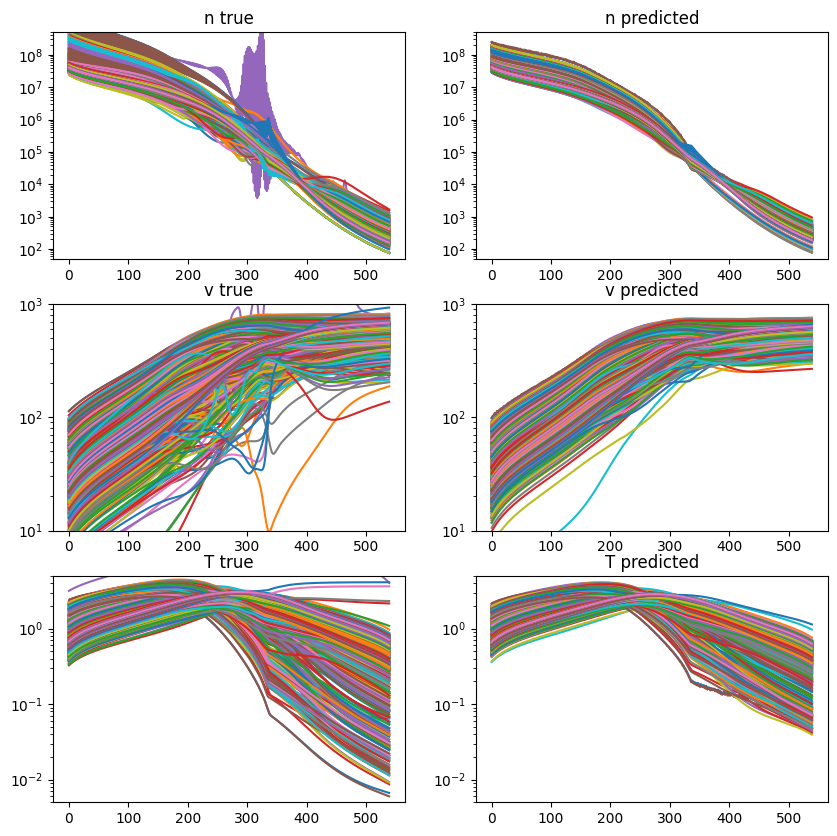

In [29]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 500000000], [10, 1000], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, :].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, :].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


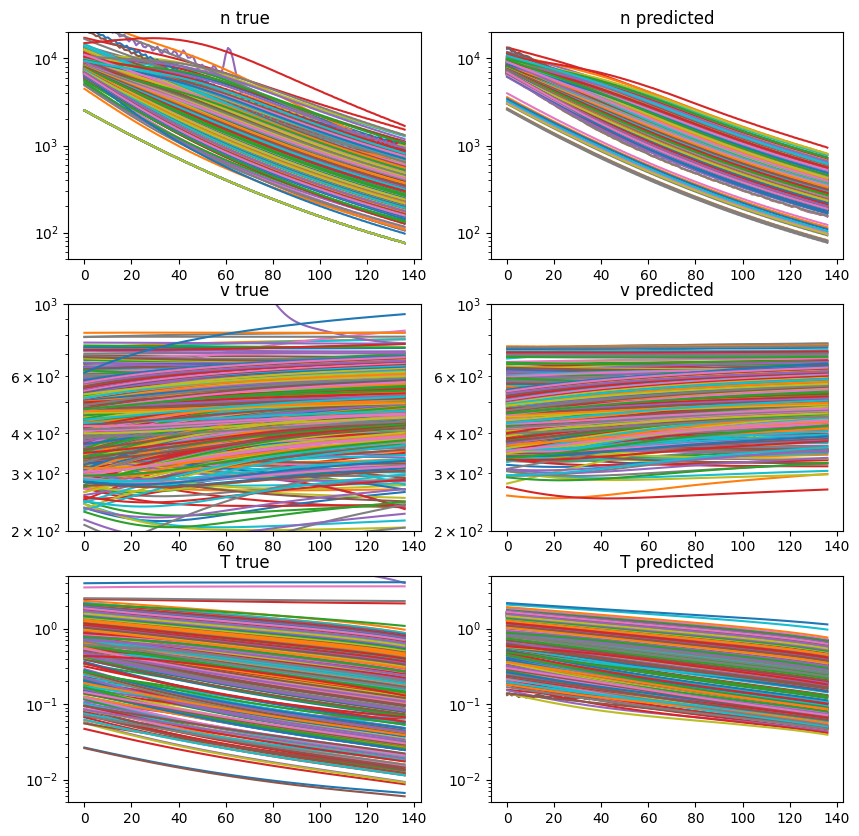

In [30]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

output_names = ['n', 'v', 'T']
lims = [[50, 20000], [200, 1000], [0.005, 5]]

for i in range(3):
    axs[i, 0].plot(y_test[:, i, 403:].T)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_ylim(lims[i])
    axs[i, 1].plot(y_pred[:, i, 403:].T)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_ylim(lims[i])
    
    axs[i, 0].set_title(f'{output_names[i]} true')
    axs[i, 1].set_title(f'{output_names[i]} predicted')
plt.show()


/tmp/ipykernel_1368487/2399967161.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  plt.plot(r_unnormalized[0, :].T, nvB[0, :].T)


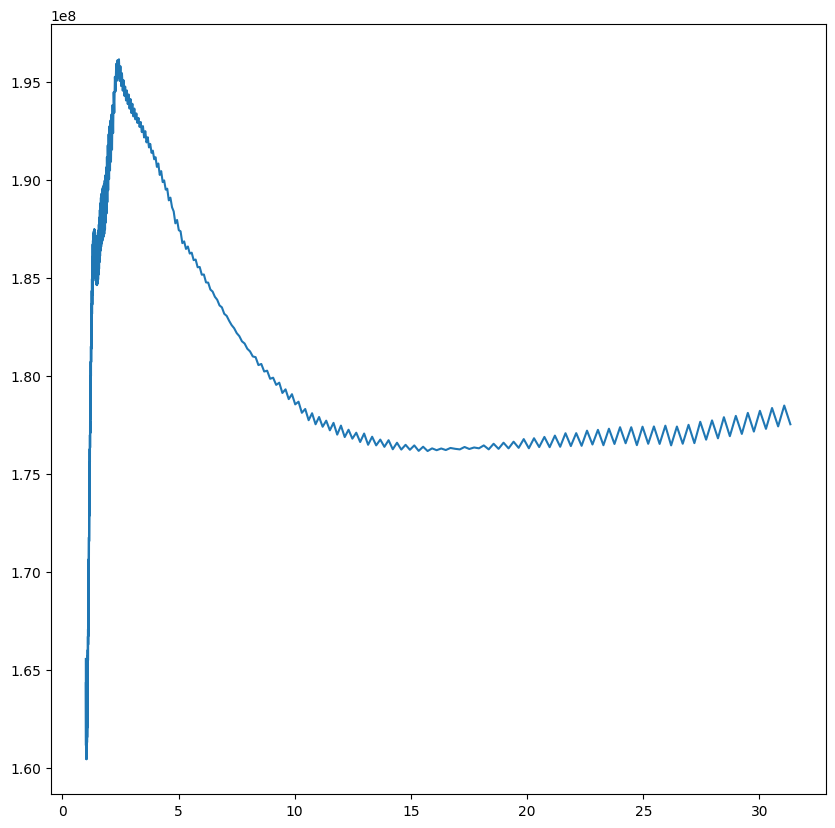

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test[:, 2, :]
r_unnormalized = X_test[:, 0, :]
n_exp = y_pred[:, 0, :]
v_unnormalized = y_pred[:, 1, :]

nvB = (n_exp * v_unnormalized) / B_unnormalized

plt.plot(r_unnormalized[0, :].T, nvB[0, :].T)
plt.show()

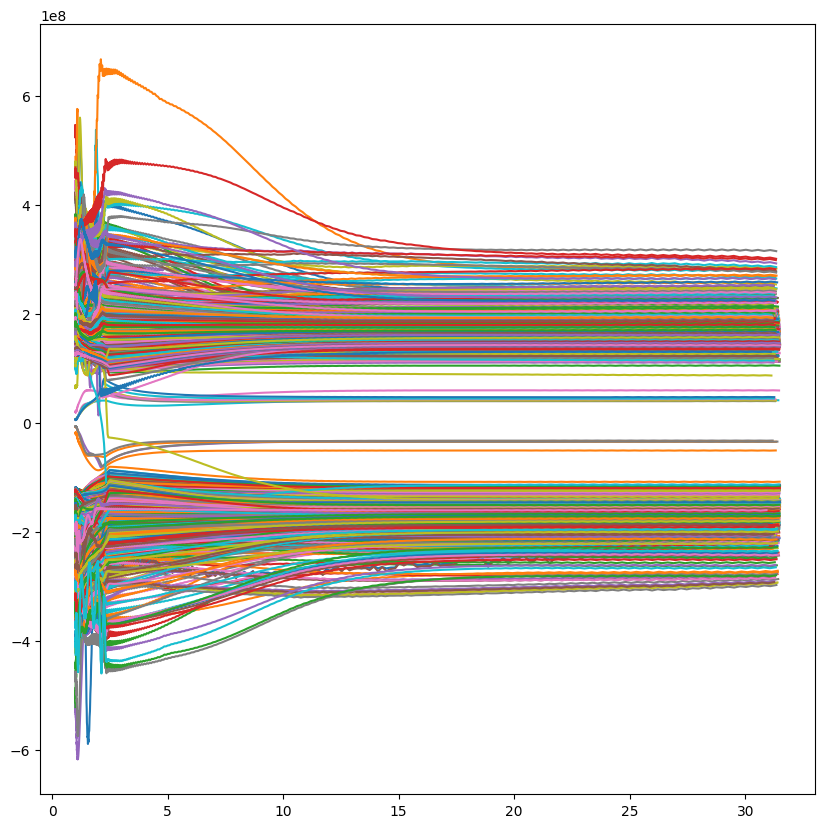

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test[:, 2, :]
r_unnormalized = X_test[:, 0, :]
n_exp = y_pred[:, 0, :]
v_unnormalized = y_pred[:, 1, :]

nvB = (n_exp * v_unnormalized) / B_unnormalized

plt.plot(r_unnormalized[:, :].T, nvB[:, :].T)
plt.show()

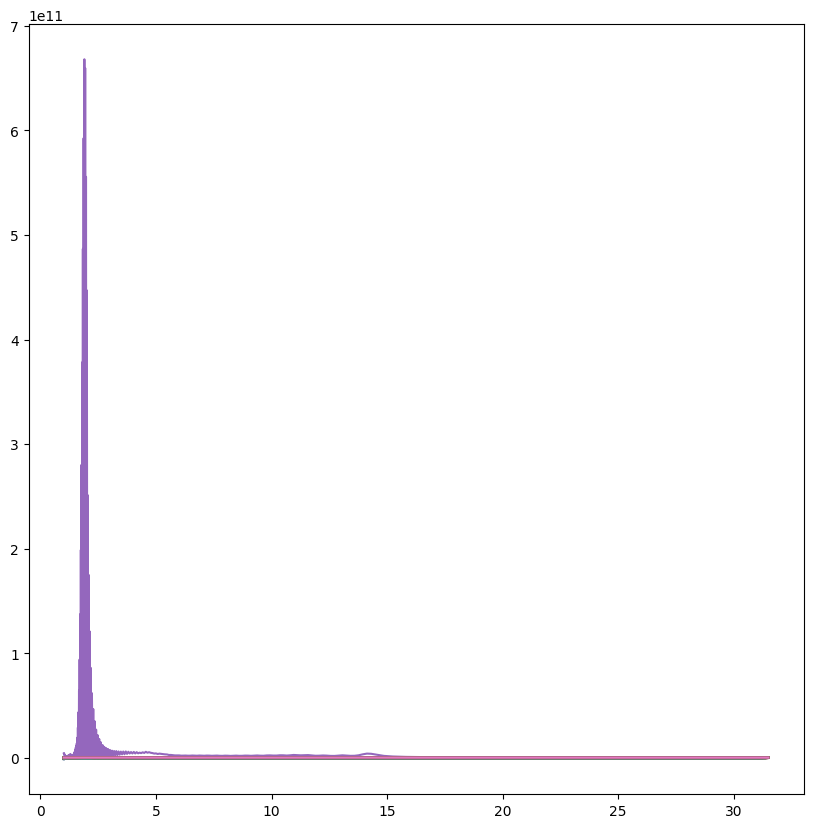

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

B_unnormalized = X_test[:, 2, :]
r_unnormalized = X_test[:, 0, :]
n_exp = y_test[:, 0, :]
v_unnormalized = y_test[:, 1, :]

nvB = (n_exp * v_unnormalized) / B_unnormalized

plt.plot(r_unnormalized[:, :].T, nvB[:, :].T)
plt.show()

In [31]:
# loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        y_pred = model(x)
        # denormalize y_pred and y
        loss = criterion(x, y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f'Test loss: {test_loss}')

Test loss: 0.036201712985571344


3 hidden layers

48 nodes

ReLU

dropout 0.2 em todas